# Instalación de Libreria

In [ ]:
!rm -rf neuralforecast
# Clone the neuralforecast repository
!git clone https://github.com/Nixtla/neuralforecast.git

# Navigate into the neuralforecast directory
%cd neuralforecast

# Checkout the specific branch that includes the KAN model
!git checkout feature/kan-experiment  # Replace 'feature/kan-model' with the actual branch name if different

# Install the package
!pip install .

Cloning into 'neuralforecast'...
remote: Enumerating objects: 12114, done.
remote: Counting objects: 100% (3323/3323), done.
remote: Compressing objects: 100% (1039/1039), done.
remote: Total 12114 (delta 2747), reused 2647 (delta 2262), pack-reused 8791
Receiving objects: 100% (12114/12114), 89.74 MiB | 36.18 MiB/s, done.
Resolving deltas: 100% (8778/8778), done.
/content/neuralforecast/neuralforecast
Branch 'feature/kan-experiment' set up to track remote branch 'feature/kan-experiment' from 'origin'.
Switched to a new branch 'feature/kan-experiment'
Processing /content/neuralforecast/neuralforecast
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neuralforecast: filename=neuralforecast-1.7.2-py3-none-any.whl size=237751 sha256=17cbb5866c23cb16527a2148cb43b21b0391a40ad0f914ecb6a0854d8d365223
  Stored in directory: /tmp/pip-ephem-wheel-cache-89271qh8/wheels/74/d0/66/97c96056b4cccce

In [ ]:
!pip install datasetsforecast

In [ ]:
from google.colab import drive
import os


In [ ]:
drive.mount('/content/drive')
shared_folder_path = '/content/drive/My Drive/proyecto_series_de_tiempo'
files = os.listdir(shared_folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['bitcoin_data_raw.parquet', '723732BTC-USD.csv', 'lstm_model_7_7.pth', 'lstm_model_7_14.pth', 'lstm_model_7_21.pth', 'lstm_model_7_28.pth', 'lstm_model_14_7.pth', 'lstm_model_14_14.pth', 'lstm_model_14_21.pth', 'lstm_model_14_28.pth', 'lstm_model_21_7.pth', 'lstm_model_21_14.pth', 'lstm_model_21_21.pth', 'lstm_model_21_28.pth', 'lstm_model_28_7.pth', 'lstm_model_28_14.pth', 'lstm_model_28_21.pth', 'lstm_model_28_28.pth', 'mlp_model_7_7.pth', 'mlp_model_7_14.pth', 'mlp_model_7_21.pth', 'mlp_model_7_28.pth', 'mlp_model_14_7.pth', 'mlp_model_14_14.pth', 'mlp_model_14_21.pth', 'mlp_model_14_28.pth', 'mlp_model_21_7.pth', 'mlp_model_21_14.pth', 'mlp_model_21_21.pth', 'mlp_model_21_28.pth', 'mlp_model_28_7.pth', 'mlp_model_28_14.pth', 'mlp_model_28_21.pth', 'mlp_model_28_28.pth', 'KAN BTC-USD', 'Proyecto Series de Tiempo.ipynb']


In [ ]:
import pandas as pd

from datasetsforecast.m3 import M3

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

from neuralforecast import NeuralForecast
from neuralforecast.models import KAN, MLP, NBEATS

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import kurtosistest, skewtest, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import torch


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_adjusted_r2(all_targets, all_predictions, model):
    n = len(all_targets)
    k = count_parameters(model)  # Total number of trainable parameters

    r2 = r2_score(all_targets, all_predictions)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f"R²: {r2:.4f}")
    print(f"R² adjusted: {r2_adj:.4f}")
    print(f"Number of trainable parameters: {k}")
    print(f"Nunmber of measures : {n}")

    return r2_adj

def evaluate_model_residues(all_predictions, all_targets):
    # model.eval()
    # all_predictions = []
    # all_targets = []
    # with torch.no_grad():
    #     for X_batch, y_batch in data_loader:
    #         outputs = model(X_batch)
    #         all_predictions.append(outputs)
    #         all_targets.append(y_batch)

    # # Concatenate all predictions and targets
    # all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy().reshape(-1)
    # all_targets = torch.cat(all_targets, dim=0).cpu().numpy().reshape(-1)

    residues = all_targets - all_predictions

    # Calculate statistics
    mape = mean_absolute_percentage_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)

    kurt_stat, kurt_p_value = kurtosistest(residues)
    skew_stat, skew_p_value = skewtest(residues)
    jb_stat, jb_p_value = jarque_bera(residues)
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residues)
    kpss_stat, kpss_p_value, _, _ = kpss(residues)

    results = {
        'MAPE': mape,
        'RMSE': rmse,
        # 'R2 adj': r2_adj,
        'R2': r2,
        'Kurtosis (statistic)': kurt_stat,
        'Kurtosis (p-value)': kurt_p_value,
        'Skewness (statistic)': skew_stat,
        'Skewness (p-value)': skew_p_value,
        'Jarque-Bera (statistic)': jb_stat,
        'Jarque-Bera (p-value)': jb_p_value,
        'Dickey Fuller (statistic)': adf_stat,
        'Dickey Fuller (p-value)': adf_p_value,
        'KPSS test (statistic)': kpss_stat,
        'KPSS test (p-value)': kpss_p_value
    }

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

    # Plotting the time series of residues
    plt.figure(figsize=(10, 6))
    plt.plot(residues)
    plt.title('Time Series of Residues')
    plt.xlabel('Time')
    plt.ylabel('Residues')
    plt.show()

    # Plotting the histogram of residues
    plt.figure(figsize=(10, 6))
    sns.histplot(residues, kde=True)
    plt.title('Histogram of Residues')
    plt.xlabel('Residues')
    plt.ylabel('Frequency')
    plt.show()

    # Q-Q plot of residues
    plt.figure(figsize=(10, 6))
    sm.qqplot(residues, line='s')
    plt.title('Q-Q Plot of Residues')
    plt.show()

    # ACF plot of residues
    plt.figure(figsize=(10, 6))
    sm.graphics.tsa.plot_acf(residues, lags=40)
    plt.title('Autocorrelation Function (ACF) of Residues')
    plt.show()

    return residues, results_df

# KAN FOR BTC-USD


Para este proyecto utilizamos la libreria:

[Neural Forecast](https://nixtlaverse.nixtla.io/neuralforecast/index.html) de [Nixtlaverse](https://nixtlaverse.nixtla.io/)


Asignación de codigos únicos para construcción de plieges.

In [ ]:
btc = pd.read_parquet(os.path.join(shared_folder_path, 'bitcoin_data_raw.parquet'))
btc = btc.reset_index().rename(columns={'Date': 'ds', 'close': 'y'})
N = 42
btc['unique_id'] = -1
btc = btc.iloc[btc.shape[0] % N:]
for i in range(0, btc.shape[0], N):
    btc.iloc[i:i+N, btc.columns.get_loc('unique_id')] = i//N

In [ ]:
btc

,ds,open,high,low,y,adj_close,volume,unique_id
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,0
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500,0
...,...,...,...,...,...,...,...,...
3525,2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,61448.394531,13800459405,83
3526,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,62901.449219,27889181179,83
3527,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,61552.789062,28186271527,83
3528,2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,66267.492188,39815167074,83


In [ ]:
btc.groupby('unique_id')['unique_id'].count()

unique_id
0     42
1     42
2     42
3     42
4     42
      ..
79    42
80    42
81    42
82    42
83    42
Name: unique_id, Length: 84, dtype: int64

Creación de conjunto de datos de testeo.

In [ ]:
horizon = 2

test_df = btc.groupby('unique_id').tail(horizon)
train_df = btc.drop(test_df.index).reset_index(drop=True)
train_df.shape, test_df.shape

((3360, 8), (168, 8))

Definición del modelo

In [ ]:
input_size = 4*horizon
# input_size = 4
models = [
    KAN(input_size=input_size,
        h=horizon,
        scaler_type='robust',
        max_steps=1000,
        early_stop_patience_steps=3),
]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Entrenamiento del módelo.

In [ ]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(train_df, val_size=horizon)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | layers       | ModuleList    | 51.2 K
-----------------------------------------------
51.2 K    Trainable params
0         Non-trainable params
51.2 K    Total params
0.205     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
preds = nf.predict()

preds = preds.reset_index()

test_df = pd.merge(test_df, preds, 'left', ['ds', 'unique_id'])

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/content/neuralforecast/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.


<Axes: >

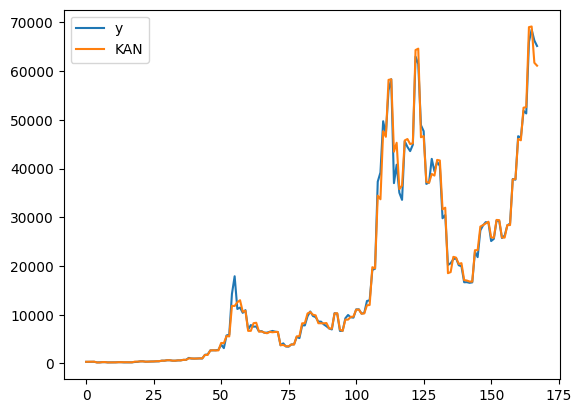

In [ ]:
test_df.y.plot(legend=True)
test_df.KAN.plot(legend=True)

En el gráfico anterior podemos ver como se ajusta la serie de tiempo de predicción con la serie objetivo. Vemos cualitativamente que hay un buen ajuste.

<ipython-input-27-95507f38aa4e>:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(residues)


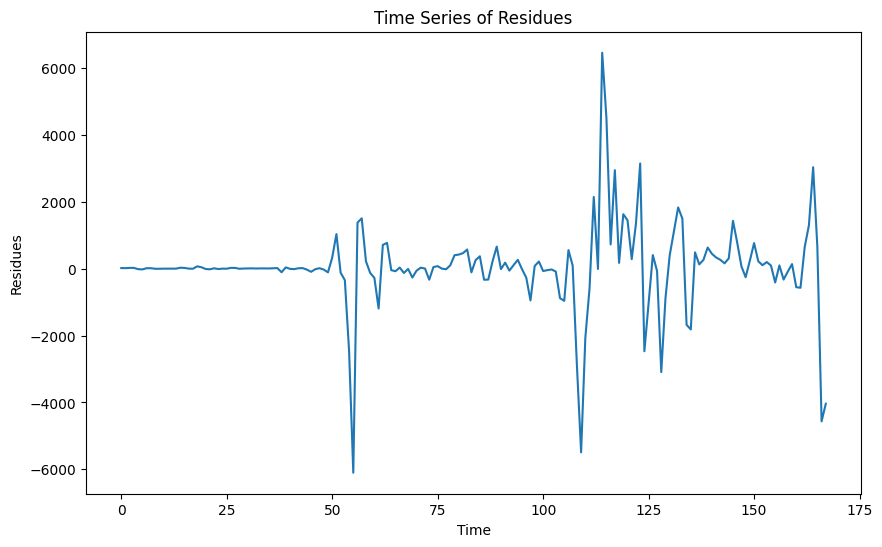

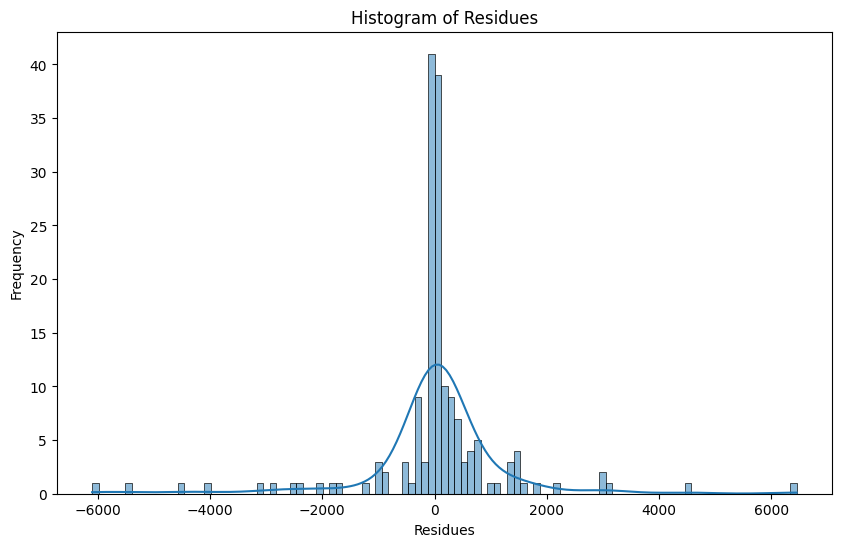

<Figure size 1000x600 with 0 Axes>

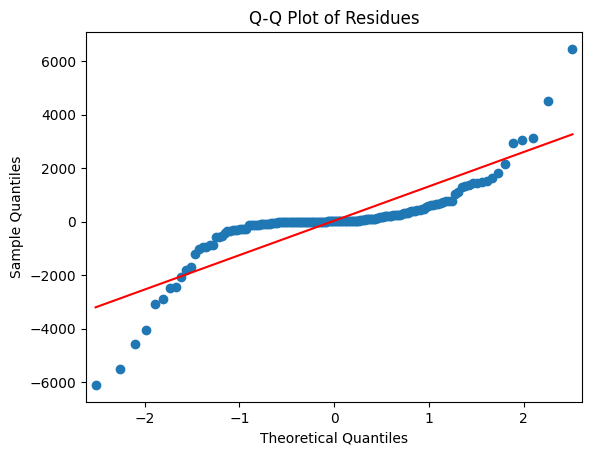

<Figure size 1000x600 with 0 Axes>

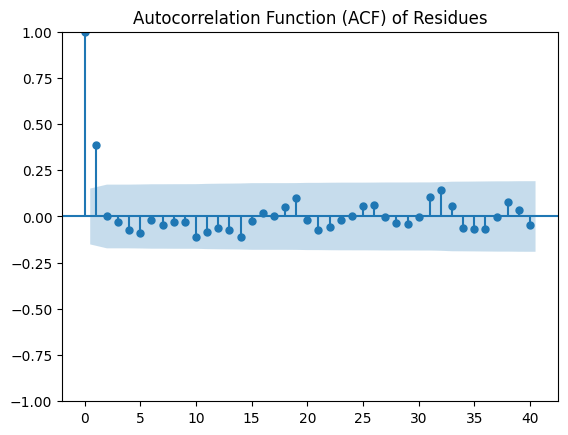

,Value
MAPE,3.940903e-02
RMSE,1.284925e+03
R2,9.949671e-01
Kurtosis (statistic),6.398856e+00
Kurtosis (p-value),1.565458e-10
Skewness (statistic),-2.875037e+00
Skewness (p-value),4.039798e-03
Jarque-Bera (statistic),6.579606e+02
Jarque-Bera (p-value),1.335573e-143
Dickey Fuller (statistic),-7.695749e+00


In [ ]:
residues, results_df = evaluate_model_residues(test_df.y, test_df.KAN)
results_df

### Métricas de Rendimiento del Modelo:

1. **MAPE (Error Porcentual Absoluto Medio):**
   - **Valor:** 3.940903e-02
   - **Explicación:** Este valor indica el error porcentual absoluto medio entre los valores predichos y los valores reales. Un MAPE de aproximadamente 3.94% sugiere que las predicciones del modelo están muy cerca de los valores reales.

2. **RMSE (Error Cuadrático Medio de la Raíz):**
   - **Valor:** 1.284925e+03
   - **Explicación:** Este valor representa la raíz cuadrada del promedio de las diferencias al cuadrado entre los valores predichos y los valores reales. Un RMSE de 1284.925 indica la magnitud del error de predicción del modelo.

3. **R² (Coeficiente de Determinación):**
   - **Valor:** 9.949671e-01
   - **Explicación:** Este valor muestra la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un R² de aproximadamente 0.995 sugiere que el modelo explica el 99.5% de la varianza en los datos, lo que indica un ajuste muy bueno.

### Propiedades Estadísticas de los Residuales:

4. **Kurtosis (estadístico):**
   - **Valor:** 6.398856e+00
   - **Explicación:** Este valor mide la "puntualidad" de la distribución de los residuales. Un valor superior a 3 indica una distribución con colas más pesadas que una distribución normal.

5. **Kurtosis (valor p):**
   - **Valor:** 1.565458e-10
   - **Explicación:** Este valor p indica la significancia del estadístico de curtosis. Un valor p muy bajo sugiere que la curtosis de los residuales se desvía significativamente de la normalidad.

6. **Skewness (estadístico):**
   - **Valor:** -2.875037e+00
   - **Explicación:** Este valor mide la asimetría de la distribución de los residuales. Una skewness negativa indica una distribución sesgada a la izquierda.

7. **Skewness (valor p):**
   - **Valor:** 4.039798e-03
   - **Explicación:** Este valor p indica la significancia del estadístico de skewness. Un valor p bajo sugiere que la skewness de los residuales se desvía significativamente de la normalidad.

8. **Jarque-Bera (estadístico):**
   - **Valor:** 6.579606e+02
   - **Explicación:** Esta prueba combina la skewness y la curtosis para comprobar si los residuales siguen una distribución normal. Un valor estadístico alto indica desviación de la normalidad.

9. **Jarque-Bera (valor p):**
   - **Valor:** 1.335573e-143
   - **Explicación:** Este valor p indica la significancia de la prueba Jarque-Bera. Un valor p muy bajo sugiere que los residuales no siguen una distribución normal.

### Pruebas de Estacionariedad:

10. **Dickey-Fuller (estadístico):**
    - **Valor:** -7.695749e+00
    - **Explicación:** Esta prueba verifica la presencia de una raíz unitaria en los residuales, lo que indicaría no estacionariedad. Un valor más negativo indica una mayor evidencia en contra de la hipótesis de raíz unitaria.

11. **Dickey-Fuller (valor p):**
    - **Valor:** 1.380837e-11
    - **Explicación:** Este valor p indica la significancia de la prueba Dickey-Fuller. Un valor p muy bajo sugiere una fuerte evidencia en contra de la hipótesis de raíz unitaria, indicando que los residuales son estacionarios.

12. **Prueba KPSS (estadístico):**
    - **Valor:** 6.944912e-02
    - **Explicación:** La prueba KPSS verifica la estacionariedad alrededor de una tendencia determinista. Un valor estadístico bajo indica que la serie probablemente es estacionaria.

13. **Prueba KPSS (valor p):**
    - **Valor:** 1.000000e-01
    - **Explicación:** Este valor p indica la significancia de la prueba KPSS. Un valor p alto (a menudo limitado a 0.1) sugiere que no se puede rechazar la hipótesis nula de estacionariedad, indicando que la serie es estacionaria.


In [ ]:
from statsmodels.tsa import stattools
alpha = 0.05
nlags = 160
acf_btc, confint_btc, qstat_btc, pvalues_btc = stattools.acf(test_df.y - test_df.KAN,
                                                                 nlags=nlags,
                                                                 qstat=True,
                                                                 alpha=alpha)
lags = set(range(1, nlags))
rejected = set(l for l, p_val in enumerate(pvalues_btc) if p_val <= alpha)
print(f'Null hypothesis is rejected at lags = {rejected}')
print(f'Null hypothesis is accepted at lags = {lags - rejected}')

Null hypothesis is rejected at lags = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82}
Null hypothesis is accepted at lags = {29, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}


Para la prueba de Ljung-Box, utilizamos la función acf del paquete statsmodels.tsa.stattools. La función acf está hecha para devolver las autocorrelaciones, los intervalos de confianza, los estadísticos y los valores de la prueba.



In [ ]:
Comprobemos si con un nivel de confianza del 95% () si se rechaza la hipótesis nula (aleatoriedad e independencia) en cualquiera de los rezagos